# Simulated Annealing calculation of minimum HF bondlength in $FHF^{-}$

As described in the companion document to this notebook, this exercise involves using the BBK integrator to perform a Langevin dynamics simulation of the HF molecule

We will start by importing a few useful libraries - these are packages of python code that provide capabilities to do numerical calculations, plot data, etc. We will then use spline fitting to compute the energy of $FHF^{-}$ as a function of the FH bondlength (holding the total length of the anion constant at the equilibrium length of 2.31 Angstroms or 4.37 in atomic units). 

Our model for the anion is rather simplistic (and not actually accurate): denoting a covalent bond as a - and a hydrogen bond as ... we model the anion as a linear structure that is either F-H...F or F...H-F, whichever is lower in energy. We'll use the energies from last time for covalent bonds (i.e. we assume the F-H covalent bond in $FHF^{-}$ behaves just like the bond in HF) and scale that energy landscape to represent the hydrogen-bond energy.

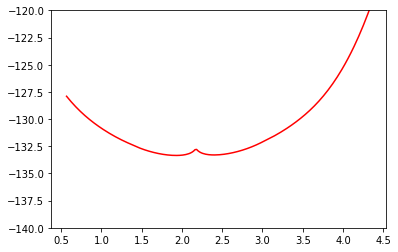

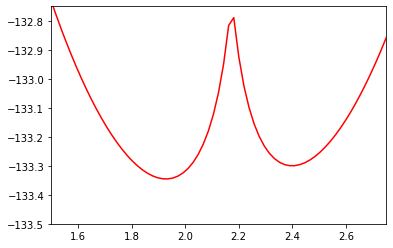

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline

molecules = []
r_array = [0.5, 0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.1] 
# energy for HF covalent bond with F at position 0 and H at corresponding position in r_array
E_FH_array = [-99.65145319155353, -99.8994262443721,-100.06621001317194,-100.17756325854646,-100.25063259195414,-100.2970313588523,-100.32474168482375,-100.33931605978479,-100.34465565789081,-100.34352787324143,-100.33791544225228,-100.31857920174716,-100.29403975969775,-100.26820624042988,-100.24311492569184,-100.21980547092805,-100.19879112534593,-100.18029259214076,-100.16434868570335,-100.15087255990257,-100.13968771534014,-100.13055798203477]

# convert r_array to atomic units
r_array_au = np.array(r_array) * 1.89
# create a cubic spline for the energies vs HF bond length in atomic units here!
E_FH_spline = InterpolatedUnivariateSpline(r_array_au, E_FH_array, k=3)

# form a much finer grid to evaluate spline object at
r_fine = np.linspace(0.3*1.89,2.3*1.89,200)

# compute the interpolated/extrapolated values for Energy on this grid
E_FH_fine = E_FH_spline(r_fine)

# now use spline to calculate energies of HF covalent bond with H at positions in r_au_array 
# and F at 2.31 Angstroms, i.e. 4.37 atomic units

E_HF_fine = E_FH_spline(4.37-r_fine)

# now model H-bonds: the H bond is about one third as strong as the covalent bond and it is about one quarter longer
# c.f. Crystals 2016, 6, 3; doi:10.3390/cryst6010003 
# (perhaps Crystals is not the best quality journal, but this paper is solid enough as essentially a review)

E_HF_hbond = E_FH_spline((4.37-r_fine)*1.25)/3
E_FH_hbond = E_FH_spline(r_fine*1.25)/3

# calculate energies of anion: minimum of FH covalent bond + HF hydrogen bond or 
# HF covalent bond and FH hydrogen bond
# also add a "restraint" to match the experimental value of 1.14 Angstroms or 2.15 atomic units
# and increase the energy barrier between the two local minima to keep things interesting

E_array = np.minimum(E_FH_fine+E_HF_hbond,E_HF_fine+E_FH_hbond)+2*(r_fine-2.15)**2+0.10/(0.1+abs(r_fine-1.15*1.89))

# now create a cubic spline for energies vs. H position (in atomic units) in atomic units

E_spline = InterpolatedUnivariateSpline(r_fine, E_array, k=3)

# compute the interpolated/extrapolated values for Energy on this grid
E_fine = E_spline(r_fine)

# plot energy landscape for FHF-

plt.plot(r_fine, E_fine, 'red')
plt.ylim(-140,-120)
plt.show()

plt.plot(r_fine, E_fine, 'red')
plt.xlim(1.5,2.75)
plt.ylim(-133.5,-132.75)
plt.show()




We now need to calculate derivatives and some sort of reduced mass (I am not sure if I am doing the latter correctly). We also will calculate the minimum energy and minimum energy position of the hydrogen atom for comparisonn with our simulated annealing results.

In [2]:
# minimum energy and energy minimizing H position
minE = min(E_fine)

Req_idx = np.argmin(E_fine)
r_eq = r_fine[Req_idx]

### print equilibrium H positions
print(" Equilibrium proton position is ",r_eq, "atomic units")
print(" Req is ",r_eq/1.89, "Angstroms")
print(" Energy mimimum is ",minE," atomic units")

# first and second derivatives

fE = E_spline.derivative()
cE = fE.derivative()


### mass of hydrogen in atomic units
mH = 1836.
### mass of fluorine in atomic units
mF = 34883.

# compute the reduced mass
mu = mH * mF/(2*mH + mF)
### Print the reduced mass!
print("Reduced mass is ",mu, "atomic units")

 Equilibrium proton position is  1.9346381909547736 atomic units
 Req is  1.0236180904522612 Angstroms
 Energy mimimum is  -133.34517330059134  atomic units
Reduced mass is  1661.138321877837 atomic units


Many minimization procedures begin with a good guess as to the lowest energy state. For our purposes, a good guess as to the lowest potential energy is that neither H-F distance would be much less than the atomic radius of F + the atomic radius of H. This sum = 0.95 Angstroms or 1.8 atomic units. We can also set r_init to specific values to see how simulated annealing works with particular starting conditions. Our lowest energy state would have 0 initial velocity, so let's start with 0 initial velocity as well. 

In [33]:
r_init = 2.4 # np.random.uniform(1.8,4.37-1.8)
v_init = 0

### print initial position
print("Initial separation is ",r_init, "atomic units")

### establish time-step for integration to be 0.02 atomic units... this is about 0.01 femtoseconds
### you may want to see what happens (e.g. to mean "instantaneous temperature" when you change this number)
dt = 0.02

### get force on particle 
F_init = -1*fE(r_init)

Initial separation is  2.4 atomic units


Next we need to define our BBK function so we can call it to update our position and velocity. Copy the BBK function you implemented for your previous computational exercise here.

In [34]:
def BBK(r_curr, v_curr, rp_curr, gamma_val, temperature_val, mu, f_interp, dt):
    ### get acceleration at current time: (force + current perturbation on force)/mass - drag
    a_curr = (-1*f_interp(r_curr) + rp_curr)/mu - gamma_val*v_curr
    
    ### update velocity for half time step, for such a small time step can approximate dv = adt
    
    # v_halftime = v_curr + 0.5*a_curr*dt
    
   
    ### use current acceleration and velocity to update position
    r_fut = r_curr + v_curr * dt + 0.5 * a_curr * dt**2
    
    ### calculate the rp_future
    
    rp_fut = np.sqrt(2*temperature_val*gamma_val*mu/dt)*np.random.normal(0,1)
    
    ### use rp_fut to get future acceleration a_fut (a_tilde at the future time in the assignment), 
    ### note that we cannot take future drag into account as we have not calculated our future velocity yet
    a_fut = (-1*f_interp(r_fut) + rp_fut)/mu
    
    ### use current and future acceleration to get future velocity v_fut
    ### note that we have to "correct" our formula relative to the formula for velocity Verlet
    ### as we have not included our future drag in our future acceleration
    
    # v_fut = (v_halftime + 0.5*a_fut*dt)/(1+0.5*gamma_val*dt)
    v_fut = (v_curr + 0.5*(a_curr + a_fut)*dt)/(1+0.5*gamma_val*dt)
    
    # v_fut = v_curr + 0.5 * (a_curr + a_fut) * dt
    
    result = [r_fut, v_fut, rp_fut]
    
    return result

Now that we have implemented the BBK algorithm as a python function, let's use it for our simulated annealing calculation. First, let's define some parameters for the calculation: you will explore how changing the temperature parameters as well as gamma effects your simulated annealing calculations.

The final value for the position of H is  2.3994274659328627  atomic units
The final value for the (potential) energy is  -133.29991561821862  atomic units


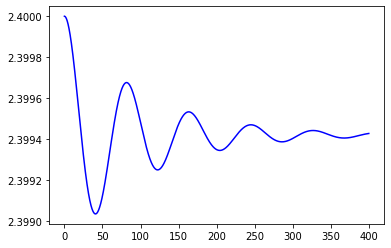

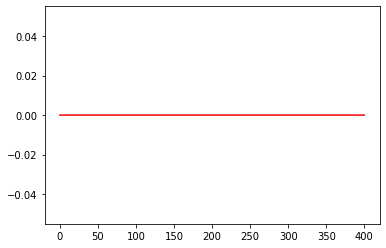

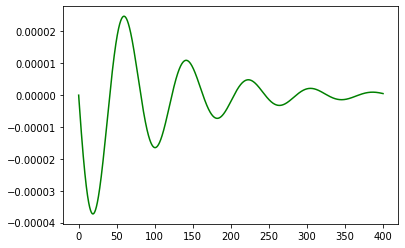

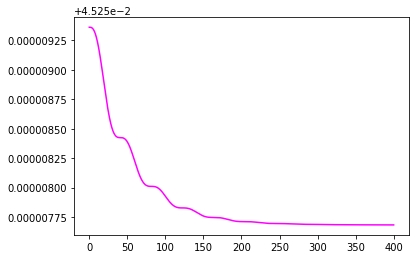

In [35]:
# set up parameters for simulated annealing run

# drag term parameter for Langevin dynamics
gamma = 0.02; # note the relatively high gamma (compared with last time)

# temperature parameters
# remember that 295 K (approximately room temperature) is 0.00094 in atomic units
temp_init = 0 
temp_hot = 0
temp_final = 0

### how many updates do you want to perform?
half_N_updates = 10000
N_updates = 2*half_N_updates

# create an array for temperatures (temp_array): start out at temp_init, at N_updates/2, temperature should be temp_hot
# then temperature at end should be temp_final

temp_array_heating = np.linspace(temp_init,temp_hot,half_N_updates)
temp_array_cooling = np.linspace(temp_hot,temp_final,half_N_updates)
temp_array = np.concatenate((temp_array_heating, temp_array_cooling),axis=None)

### use parameters set above to get initial perturbation of force for Langevin dynamics
rp_init = np.sqrt(2*temp_init*gamma*mu/dt)*np.random.normal(0,1)


### Now use r_init and v_init and run velocity verlet update N_updates times, plot results
### these arrays will store the time, the position vs time, and the velocity vs time
### as weell as energy and "instantaneous temperature" (Eq. 3.18 in Cramer, note that we have 1 dof)
r_vs_t = np.zeros(N_updates)
v_vs_t = np.zeros(N_updates)
e_vs_t = np.zeros(N_updates)
temp_vs_t = np.zeros(N_updates)
t_array = np.zeros(N_updates)

### first entry is the intial position and velocity
r_vs_t[0] = r_init
v_vs_t[0] = v_init
e_vs_t[0] = (E_spline(r_init)-minE)+0.5*mu*v_init**2 

### first BBK update
### note that the result of a BBK call is an array whose elements are position, velocity and a perturbation term
result_array = BBK(r_init, v_init, rp_init, gamma, temp_array[0], mu, fE, dt)

### do the update N_update-1 more times
for i in range(1,N_updates):
    tmp = BBK(result_array[0], result_array[1], result_array[2], gamma, temp_array[i], mu, fE, dt)
    result_array = tmp
    t_array[i] = dt*i
    r_vs_t[i] = result_array[0]
    v_vs_t[i] = result_array[1]
    e_vs_t[i] = (E_spline(result_array[0])-minE)+0.5*mu*result_array[1]**2

print("The final value for the position of H is ", result_array[0], " atomic units")
''' figure out to print the % difference between the final value for the position of H'''
''' and the equilibrium value calculated above'''

print("The final value for the (potential) energy is ", E_spline(result_array[0]), " atomic units")
''' figure out to print the difference between the final value for potential energy'''
''' and the minimum energy value calculated above'''

    
### Plot the trajectory of bondlength vs time: 
# does the bondlength seem to converge to the equilibrium bondlength calculated above?
plt.plot(t_array, r_vs_t, 'blue')
plt.show()
    
### Plot the temparature as a function of time
plt.plot(t_array, temp_array,'red')
plt.show()

### Plot the velocity as a function of time
plt.plot(t_array, v_vs_t,'green')
plt.show()

### plot the total energy vs. time:
# does the average energy seem to converge to the minimum energy (i.e. 0 given how we set up this plot)?
plt.plot(t_array,e_vs_t,'magenta')
plt.show()
    